In [2]:
!pip -q install ipython-sql SQLAlchemy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00


In [5]:
import kagglehub

In [6]:
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lending-club' dataset.
Path to dataset files: /kaggle/input/lending-club


In [7]:
import os
import pandas as pd

In [8]:
for file in os.listdir(path):
    print(file)

rejected_2007_to_2018Q4.csv.gz
accepted_2007_to_2018Q4.csv.gz
accepted_2007_to_2018q4.csv
rejected_2007_to_2018q4.csv


In [9]:
import os
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("wordsforthewise/lending-club")

accepted_df = pd.read_csv(os.path.join(path, 'accepted_2007_to_2018Q4.csv.gz'), low_memory=False)
display(accepted_df.head())

Using Colab cache for faster access to the 'lending-club' dataset.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
import pandas as pd

# Keep the most useful columns for SQL analysis
keep_cols = [
    "id", "issue_d", "term", "grade", "sub_grade", "addr_state",
    "loan_amnt", "funded_amnt", "int_rate", "installment",
    "annual_inc", "dti", "fico_range_low", "fico_range_high",
    "purpose", "loan_status"
]

df = accepted_df[keep_cols]
df.rename(columns={
    "addr_state": "state",
    "loan_amnt": "loan_amount",
    "int_rate": "interest_rate",
    "loan_status": "status"
}, inplace=True)

df.head(3)


/tmp/ipython-input-1201806479.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={


,id,issue_d,term,grade,sub_grade,state,loan_amount,funded_amnt,interest_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,purpose,status
0,68407277,Dec-2015,36 months,C,C4,PA,3600.0,3600.0,13.99,123.03,55000.0,5.91,675.0,679.0,debt_consolidation,Fully Paid
1,68355089,Dec-2015,36 months,C,C1,SD,24700.0,24700.0,11.99,820.28,65000.0,16.06,715.0,719.0,small_business,Fully Paid
2,68341763,Dec-2015,60 months,B,B4,IL,20000.0,20000.0,10.78,432.66,63000.0,10.78,695.0,699.0,home_improvement,Fully Paid


In [13]:
from sqlalchemy import create_engine

In [14]:
engine = create_engine("sqlite:///loans.db", echo=False)
df.to_sql("loans", con=engine, if_exists="replace", index=False)

2260701

In [15]:
%load_ext sql
%sql sqlite:///loans.db

In [16]:
%%sql
SELECT COUNT(*) AS total_loans FROM loans;

%%sql
SELECT DISTINCT grade FROM loans;

%%sql
SELECT state, ROUND(SUM(loan_amount)/1e6,2) AS total_million
FROM loans
GROUP BY state
ORDER BY total_million DESC
LIMIT 10;


 * sqlite:///loans.db
Done.
(sqlite3.OperationalError) near "%": syntax error
[SQL: %%sql
SELECT DISTINCT grade FROM loans;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [26]:
%load_ext sql
%sql sqlite:///loans.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [27]:
%%sql
CREATE VIEW IF NOT EXISTS loans_simple AS
SELECT
  id,
  grade,
  sub_grade,
  state,
  purpose,
  loan_amnt AS loan_amount,
  CAST(REPLACE(int_rate, '%', '') AS REAL) AS interest_rate,
  annual_inc,
  dti,
  term,
  loan_status AS status
FROM loans
WHERE int_rate IS NOT NULL
  AND loan_amnt IS NOT NULL
  AND loan_status IS NOT NULL;

 * sqlite:///loans.db
Done.


[]

In [28]:
%%sql
SELECT
  grade,
  ROUND(AVG(interest_rate), 2) AS avg_interest_rate,
  COUNT(*) AS total_loans
FROM loans_simple
GROUP BY grade
ORDER BY grade;

 * sqlite:///loans.db
(sqlite3.OperationalError) no such column: loan_amnt
[SQL: SELECT
  grade,
  ROUND(AVG(interest_rate), 2) AS avg_interest_rate,
  COUNT(*) AS total_loans
FROM loans_simple
GROUP BY grade
ORDER BY grade;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [30]:
import sqlite3

# Connect to your existing DB
conn = sqlite3.connect("loans.db")

# Get column names for the 'loans' table
cursor = conn.execute("PRAGMA table_info(loans);")
cols = cursor.fetchall()

print("📊 Columns in loans table:\n")
for col in cols:
    print(col[1])


📊 Columns in loans table:

id
issue_d
term
grade
sub_grade
state
loan_amount
funded_amnt
interest_rate
installment
annual_inc
dti
fico_range_low
fico_range_high
purpose
status


In [32]:
%%sql
DROP VIEW IF EXISTS loans_simple;

CREATE VIEW loans_simple AS
SELECT
  id,
  grade,
  sub_grade,
  state,
  purpose,
  loan_amount,
  -- interest_rate might be '13.56%' (TEXT) or numeric; handle both safely:
  CASE
    WHEN typeof(interest_rate) = 'text'
      THEN CAST(REPLACE(interest_rate, '%', '') AS REAL)
    ELSE CAST(interest_rate AS REAL)
  END AS interest_rate,
  annual_inc,
  dti,
  term,
  status
FROM loans
WHERE interest_rate IS NOT NULL
  AND loan_amount IS NOT NULL
  AND status IS NOT NULL;

 * sqlite:///loans.db
Done.
Done.


[]

In [37]:
from sqlalchemy import create_engine, text

engine = create_engine("sqlite:///loans.db", echo=False)
df.to_sql("loans", engine, if_exists="replace", index=False)

# Create a minimal clean view
with engine.begin() as conn:
    conn.execute(text("DROP VIEW IF EXISTS loans_simple;"))
    conn.execute(text("""
        CREATE VIEW loans_simple AS
        SELECT
          id, grade, sub_grade, state, purpose,
          loan_amount,
          interest_rate,
          annual_inc, dti, term, status
        FROM loans
        WHERE interest_rate IS NOT NULL
          AND loan_amount IS NOT NULL
          AND status IS NOT NULL;
    """))

CASE 1 – Interest Rate vs Credit Grade

In lending, every borrower is assigned acredit grade that represents their risk level — Grade A borrowers are the most creditworthy, while Grade G borrowers are the riskiest.

According to risk–return theory in finance:
*“Higher risk should yield higher expected return.”
So, lenders compensate for riskier borrowers by charging higher interest rates.


We used SQL to:

-Group all loans by their credit grade.

-Calculate the average interest rate for each grade.

-Count how many loans exist per grade to measure distribution. **bold text**

In [38]:
q1 = """
SELECT
  grade,
  ROUND(AVG(interest_rate), 2) AS avg_interest_rate,
  COUNT(*) AS total_loans
FROM loans_simple
GROUP BY grade
ORDER BY grade;
"""
analysis1_df = pd.read_sql_query(q1, engine)
analysis1_df

,grade,avg_interest_rate,total_loans
0,A,7.08,433027
1,B,10.68,663557
2,C,14.14,650053
3,D,18.14,324424
4,E,21.83,135639
5,F,25.45,41800
6,G,28.07,12168


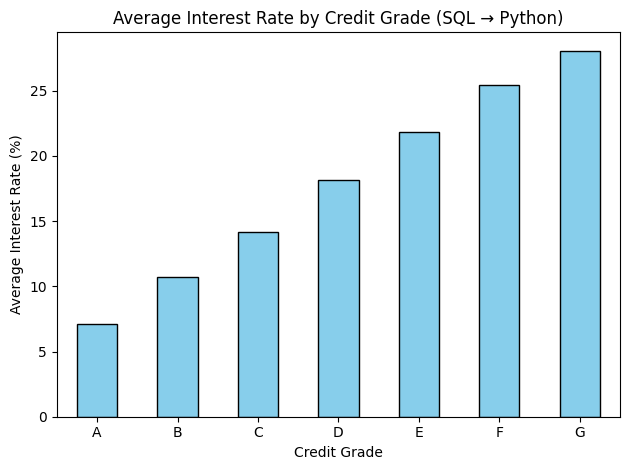

In [44]:
# --- Chart 1: Visualizing Average Interest Rate by Grade ---
import matplotlib.pyplot as plt

ax = grade_df.plot(
    x="grade", y="avg_interest_rate", kind="bar",
    title="Average Interest Rate by Credit Grade (SQL → Python)",
    color="skyblue", edgecolor="black", legend=False, rot=0
)
ax.set_xlabel("Credit Grade")
ax.set_ylabel("Average Interest Rate (%)")
plt.tight_layout()
plt.show()

CASE 2 - Default Rate by Loan Purpose

Different loan types attract different risk levels.

Debt consolidation / credit card loans are usually smaller and have steady repayment patterns.

Small business loans, on the other hand, depend on business performance and are riskier.
By analyzing default rates per loan purpose, we can identify risk-heavy lending categories and adjust pricing or underwriting policies.



We used SQL to:

Group all loans by their purpose.

Count the total loans and total defaults in each category.

Compute the default rate = (defaults / total loans) × 100.

,purpose,total_loans,avg_interest,default_rate
0,small_business,24689,15.26,18.84
1,renewable_energy,1445,14.73,15.36
2,moving,15403,14.74,14.47
3,debt_consolidation,1277877,13.52,12.94
4,medical,27488,13.63,12.41
5,wedding,2355,14.15,12.40
6,other,139440,14.24,11.84
7,house,14136,14.40,11.31
8,vacation,15525,13.45,11.23
9,major_purchase,50445,12.76,10.90


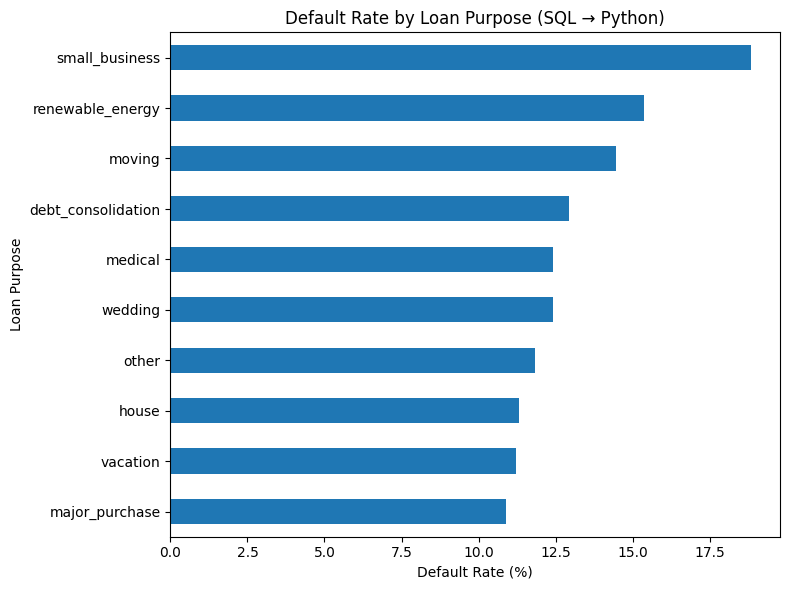

In [48]:
# --- Analysis 2 end-to-end: Default Rate by Loan Purpose (SQL → Pandas → Chart) ---
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

# 0) Make sure the simple view exists (safe to re-run)
with engine.begin() as conn:
    conn.execute(text("DROP VIEW IF EXISTS loans_simple;"))
    conn.execute(text("""
        CREATE VIEW loans_simple AS
        SELECT
          id, grade, sub_grade, state, purpose,
          loan_amount,
          CAST(interest_rate AS REAL) AS interest_rate,
          annual_inc, dti, term, status
        FROM loans
        WHERE interest_rate IS NOT NULL
          AND loan_amount IS NOT NULL
          AND status IS NOT NULL;
    """))

# 1) Query → purpose_df
q_purpose = """
SELECT
  purpose,
  COUNT(*) AS total_loans,
  ROUND(AVG(interest_rate), 2) AS avg_interest,
  ROUND(
    SUM(CASE WHEN status LIKE '%Charged Off%' OR status='Default' THEN 1 ELSE 0 END)
    * 100.0 / COUNT(*), 2
  ) AS default_rate
FROM loans_simple
GROUP BY purpose
HAVING COUNT(*) >= 1000
ORDER BY default_rate DESC
LIMIT 10;
"""
purpose_df = pd.read_sql_query(q_purpose, engine)
display(purpose_df)

# If HAVING 1000 filters everything out (small sample), relax it:
if purpose_df.empty:
    q_purpose_relaxed = q_purpose.replace(">= 1000", ">= 100")
    purpose_df = pd.read_sql_query(q_purpose_relaxed, engine)
    print("⚠️ Few rows per purpose. Relaxed threshold to 100.")
    display(purpose_df)

# 2) Plot
ax = purpose_df.sort_values("default_rate").plot(
    x="purpose", y="default_rate",
    kind="barh", figsize=(8, 6),
    title="Default Rate by Loan Purpose (SQL → Python)",
    legend=False
)
ax.set_xlabel("Default Rate (%)")
ax.set_ylabel("Loan Purpose")
plt.tight_layout()
plt.show()

CASE 3 - Income vs Default Risk — Affordability and Creditworthiness

In credit risk modeling, debt-to-income ratio (DTI) and annual income are among the strongest predictors of default.

Borrowers with higher income generally have better repayment capacity.

Lower-income borrowers are more likely to default under financial stress, even at similar loan amounts.

By analyzing default rates across income groups, we can confirm whether income and credit performance are positively correlated.

We grouped borrowers into income brackets and calculated the default rate for each bracket.

In [41]:
q_income = """
SELECT
  CASE
    WHEN annual_inc < 40000 THEN '<40k'
    WHEN annual_inc BETWEEN 40000 AND 80000 THEN '40k–80k'
    WHEN annual_inc BETWEEN 80000 AND 120000 THEN '80k–120k'
    WHEN annual_inc BETWEEN 120000 AND 200000 THEN '120k–200k'
    ELSE '>200k'
  END AS income_group,
  COUNT(*) AS total_loans,
  ROUND(
    SUM(CASE WHEN status LIKE '%Charged Off%' OR status='Default' THEN 1 ELSE 0 END) * 100.0
    / COUNT(*), 2
  ) AS default_rate_pct
FROM loans_simple
WHERE annual_inc IS NOT NULL
GROUP BY income_group
ORDER BY
  CASE income_group
    WHEN '<40k' THEN 1
    WHEN '40k–80k' THEN 2
    WHEN '80k–120k' THEN 3
    WHEN '120k–200k' THEN 4
    ELSE 5
  END;
"""

income_df = pd.read_sql_query(q_income, engine)
display(income_df)

,income_group,total_loans,default_rate_pct
0,<40k,351460,14.28
1,40k–80k,1148931,12.72
2,80k–120k,486987,10.31
3,120k–200k,219894,8.60
4,>200k,53392,7.31


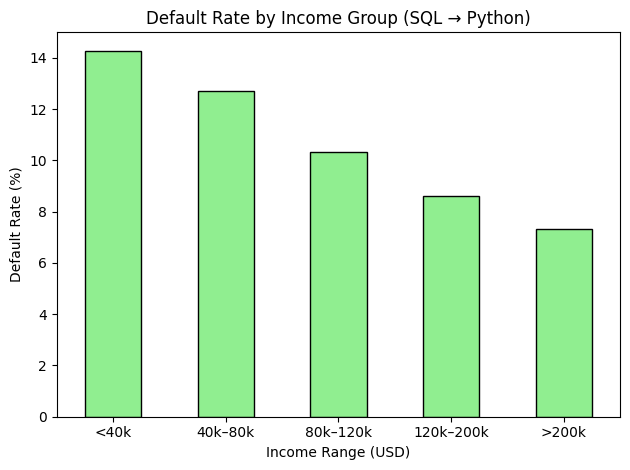

In [46]:
# --- Chart 3: Default Rate by Income Group ---
ax = income_df.plot(
    x="income_group", y="default_rate_pct",
    kind="bar", color="lightgreen", edgecolor="black",
    title="Default Rate by Income Group (SQL → Python)",
    legend=False, rot=0
)
ax.set_xlabel("Income Range (USD)")
ax.set_ylabel("Default Rate (%)")
plt.tight_layout()
plt.show()